# MATH80629A
# Week \#7 - Unsupervised Learning - Exercises

This practical session will focus on two tasks which used unsupervised learning, namely clustering (Sections 7.2 and 7.3) and dimensionality reduction (Section 7). The goal of this tutorial is to develop basic intuition behind some classic algorithms used for unsupervised learning (k-means, GMMs, and autoencoders).

In [1]:
# Classic libraries
import pandas as pd
import numpy as np

# Data science libraries
import sklearn as sk
from sklearn.cluster import KMeans   # KMeans function
from sklearn.datasets import make_circles, make_blobs  # Datasets
from sklearn.model_selection import train_test_split   # Cross validation library
from sklearn import mixture

# Data visualization libaries
import matplotlib.pyplot as plt
# A must! For nice an easy figures - look for sns command in the notebook
import seaborn as sns   
from matplotlib.pyplot import cm # This is a nice color chart

%matplotlib inline

# Code to obtain utilities.py
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/utilities.py
!mkdir Images
!wget -nc -P Images https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/Images/AE.png

# Homemade libraries
from utilities import color, super_scat_it, distance, initiate, estimate_centroid

File ‘utilities.py’ already there; not retrieving.

mkdir: Images: File exists
File ‘Images/AE.png’ already there; not retrieving.



## 7.1 Data generation

Let's first look at [Gaussian mixtures](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model), a relatively simple model, which we will generate with the [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs) function. 

**Remark**: In order to properly run Section 7.2.1, do not change the attributes of the `make_blobs` function in the code snippet below.

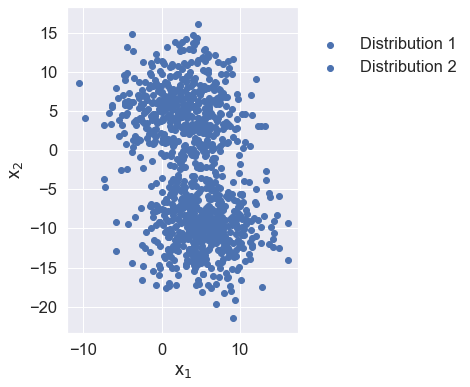

In [2]:
nb_obs = 1000   # Number of observation
k = 2   # Number of clusters
std = 4   # Standard deviation associated to the isotopic Gaussian Mixture - 
dim = 2   # Covariates dimension - if dim > 2, 
          # don't expect data vizualisation from matplotlib!
seed = 10   # Random seed to replicate the experience

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std= std, 
                  n_features=dim, random_state=seed)   # Data generation

super_scat_it(X, y, k)   # Data visualization - see utilities.py script

## 7.2 Clustering: K-means Algorithm


### 7.2.1 Implementation with numpy

The objective of this section is to implement and understand the procedures associated with the k-means algorithm. First, we will therefore implement the k-means algorithm with numpy.

**Question 7.1**

According to the pseudo-code presented on [Slide 18 of the course](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_unsupervised.pdf), complete the `fit` function of the `k_means` class below.

**Answer 7.1**

In [3]:
class k_means:

    def __init__(self, data, k, seed=None):
        """
        Args:
            data: unlabeled data
            k: number of cluster
        Class Attributes:
            self.data: unlabeled data
            self.centroid: cluster centers
            self.label: label 
        """
        
        self.data = data
        self.centroid = initiate(data, k)
        self.label = np.argmin(distance(self.data, self.centroid ), axis=1)
            
    def fit(self):
        
        # step 1. update the cluster centers
        self.centroid = estimate_centroid(self.data, self.label)
        # step 2. update the responsibilities (i.e., the cluster each point belongs to)
        label_new = np.argmin(distance(self.data, self.centroid), axis=1)
        
        # run both steps until convergence        
        while label_new.tolist() != self.label.tolist():
            self.label = label_new
            # step 1.
            self.centroid = estimate_centroid(self.data, self.label)
            # step 2.
            label_new = np.argmin(distance(self.data, self.centroid), axis=1)
                        
        self.label = label_new
        # compute the objective function
        self.objective = np.mean(np.min(distance(self.data, self.centroid), axis=1)) 

We can now call the above `k_means` class, estimate the centroids and visualize the associated clusters!

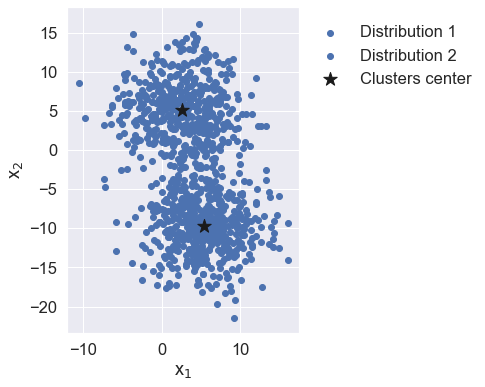

In [4]:
km = k_means(X, k)
km.fit()

super_scat_it(X, km.label, dim, km.centroid)

### 7.2.2 Exploration of the K-means Algorithm with Scikit Learn

Once the algorithm has been coded, we are going to make our life easier and simply use the [Scikit Learn library](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (-_-).  First, let's check that everything is running fine.

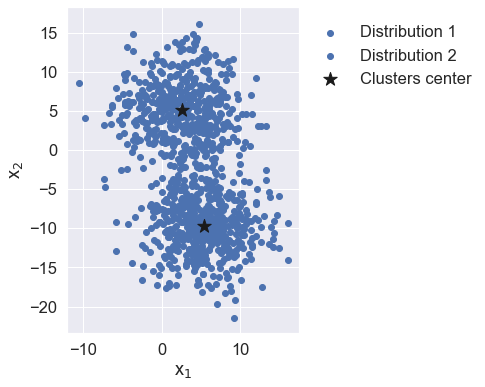

In [5]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
super_scat_it(X, kmeans.labels_, dim, kmeans.cluster_centers_)

### 7.2.3 Choosing the optimal number of clusters

In our first experiment, we knew the actual number clusters (parameterized by the variable $ k $). In most non-simulated datasets, we do not have the luxury of knowing the "best" number of clusters ahead of time. It is therefore important to develop methodologies in order to clearly define the number of clusters required.

**Questions 7.2**

1. Find a simple way to determine the optimal number of clusters.
2. Implement it.
3. How many clusters would you choose?

**Answers 7.2**

1. We can implement cross-validation. Hence, we could define a threshold from which a decrease in the value of the objective function is no longer considered interesting.  We could also do a statistical inference test in this context. In practice the [F-Test](https://en.wikipedia.org/wiki/F-test) can be used.
2. Cross-validation is implemented below.
3. 2 clusters seems a fair choice.

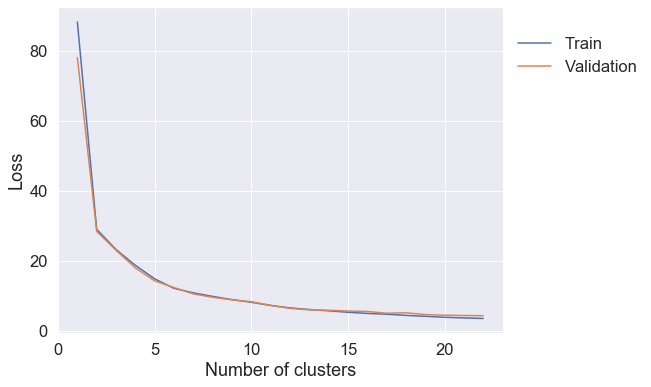

In [6]:
# get a validation dataset
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []

# try for all values of k from 1 to max_cluster
max_cluster = 22

for k in np.arange(max_cluster)+1:
    # fit our kmeans model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    # keep track of the train and validation errors1
    loss_train.append(np.mean(np.min(distance(X_train, kmeans.cluster_centers_), axis=1)))
    loss_valid.append(np.mean(np.min(distance(X_valid, kmeans.cluster_centers_), axis=1)))

# plot the errors 
plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Number of clusters')
plt.ylabel('Loss')

leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

<!-- 
**Questions 7.3**

   1. Are you disappointed by the behaviour of the curve associated to the validation set?
   2. Considering the results obtained here, could you imagine a better way to know the optimal number of clusters?
   
**Answers 7.3**

   1. In hindsight it makes sense, see our justification below.
   2. Yes indeed! ***A statistical inference technique:***  The loss function considered aims at minimizing the variance within the different clusters (that's what the objective function says). Therefore, the question comes down to asking whether the addition of a new cluster sufficiently reduces the intra-cluster variance. However, under the assumption of normality of the observations, which is the case in our simulated data, we can suppose that each of the variances under study follows a chi-square distribution (!). We could therefore create a test in order to know if the sums of the chi squares, in the case where we have $k$ or $k + 1$ clusters, are significantly different. This associated test is the [F-test](https://en.wikipedia.org/wiki/F-test)!
--> 

The previous exercise was based on a relatively simple dataset. Indeed, there was a large number of observations ($n = 1000$) for a relatively small variable space ($\bf{X} \in \mathbb{R}^2$) and small number of clusters ($k = 2$). In order to validate the relevance of the cross-validation procedure to fix the number of clusters, let's now simulate a slightly more complex dataset.

In [7]:
nb_obs = 100   # Number of observation
k = 10   # Number of clusters
std = 4   # Standard deviation associated to the isotopic Gaussian Mixture - 
dim = 50   # Covariates dimension - if dim > 2, 
           # (don't expect data vizualisation from matplotlib)
seed = 10   # Random seed to replicate the experience

# Data generation
X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std= std, 
                  n_features=dim, random_state=seed)

Let's now look how the loss associated to the validation set behave on a more complex dataset.

(80, 50)


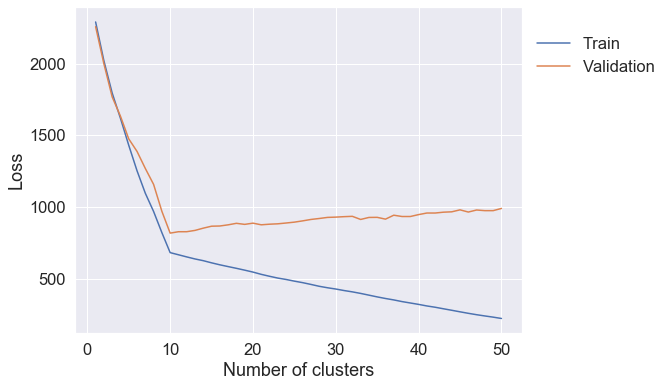

In [8]:
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []
print(X_train.shape)

max_cluster = 50

for k in np.arange(max_cluster)+1:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    loss_train.append(np.mean(np.min(distance(X_train, kmeans.cluster_centers_), axis=1)))
    loss_valid.append(np.mean(np.min(distance(X_valid, kmeans.cluster_centers_), axis=1)))

plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Number of clusters')
plt.ylabel('Loss')

# Ghosting the legend
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

**Questions 7.4**

   1. Are you surprised by the behaviour of the curve associated with the training set?
   2. Are you disappointed by the behaviour of the curve associated with the validation set?
    
**Answers 7.4**

   1. That's what exactly what we expected. Ultimately, the curve associated to the training dataset will converge (with respect to the number of clusters) to 0 (make sure you understand why).
   2. According to the above figure, the validation curve finds a minimum at 10 clusters! In practice, you should ensure that the loss (y-axis) is reasonable for the application you have in mind. You may wish to consider other objectives which could lead to a different number of clusters.


## 7.3 Clustering - The Gaussian Mixture Model

We now consider the [Expectation Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) (EM) in order to estimate mixtures of Gaussians. As presented on [Slides 26 to 41 of the course](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_unsupervised.pdf), the idea is simply to associate each observation with a probability of belonging to one or the other of the distributions.

Coding the EM algorithm in numpy can be a tedious exercise, so we'll just use the GMM implementation provided by sklearn: [sklearn GMMs](https://scikit-learn.org/0.16/modules/generated/sklearn.mixture.GMM.html)

No handles with labels found to put in legend.


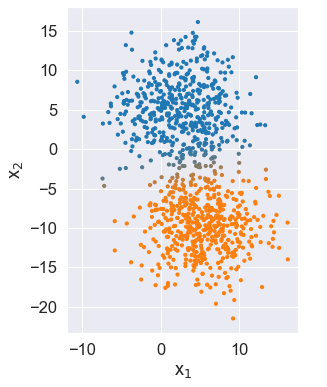

In [9]:
# first, we generate some data
cluster_std=4
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=cluster_std, 
                  n_features=2, random_state=10)

# fit the GMM model
nb_components = 2
GMM = mixture.GaussianMixture(n_components=nb_components, 
                              covariance_type='full')
GMM.fit(X)

# Plot the clustering result, where the color of the points indicate
# to which cluster they probabilistically belong to.
super_scat_it(X, GMM.predict_proba(X), dim=nb_components, 
              clusters_center=0, task='EM')

**Questions 7.5**

1. After a quick glance at the figure above, what do you notice that is different from the k-means algorithm?
2. What would have happened if we had set the parameter associated with the variance of the sub-populations (`cluster_std`) to 2?

**Answers 7.5**

1. Some observations seem to have a "mixed assignment." This is expected, since the responsibilities assigned in a GMM can be considered as probabilities.
2. Try it!

### 7.3.1 Choosing the optimal number of clusters for a GMM

**Questions 7.6**

1. How do we find the right number of clusters?
2. Do the train/validation curves behave similarly to those of the k-means algorithm (e.g. in Section 7.2.3)? Does it make sense?
2. Could you imagine another way to find the optimal number of mixtures?

**Answers 7.6**

1. As previously seen, we can use cross-validation (see code below).
2. Note that we are maximizing the objective (so higher is better in the plot). GMMs are a probabilistic approach based on the **maximization** of the likelihood. With that in mind, the behaviour of train/validation results are similar as above with k-means. In the figure below for instance, we can see that the algorithm aims to maximize the log-likelihood (the training curve monotonically increases) while the validation curve reaches a global maximum for $k = 2$.
3. In machine learning we tend to stick with the validation set. However, we could use a model selection criterium from the statistics literature such as the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) which penalized nonparsimonious models. 

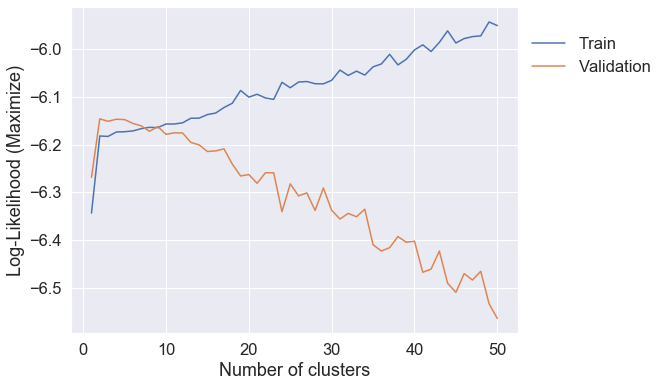

In [10]:
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []

for k in np.arange(max_cluster)+1:
    GMM = mixture.GaussianMixture(n_components=k, covariance_type='full')
    GMM.fit(X_train)
    
    loss_train.append(GMM.score(X_train))
    loss_valid.append(GMM.score(X_valid))
            
plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Number of clusters')
plt.ylabel('Log-Likelihood (Maximize)')

# Ghosting the legend
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

## 7.4 Dimensionality Reduction: Autoencoder

### 7.4.1 Model

Autoencoders (AE) are a class of neural networks that allow unsupervised learning of the latent characteristics of the data being studied (see capsule 4 of week 7 or [Chapter 14](http://www.deeplearningbook.org/contents/autoencoders.html) of the [Deep Learning book](http://www.deeplearningbook.org/)). To do this, the AE will attempt to predict, or copy, the input observations using (multiple) transformations (hidden layer). In its simplest form, the architecture of an AE can be summarized in the diagram below.

![title](./Images/AE.png)

Looking more closely, the AE consists of an encoder, the function $h(\cdot)$ defined by:

$$
\begin{align}
    h(\mathbf{x}) = \frac{1}{1+ \exp(-\mathbf{W} \mathbf{x})}.
\end{align}
$$

This function takes as input the observations and will consist of recoding it as a hidden layer so as to reduce their size (fewer neurons). Afterwards, the decoder defined by:

$$
\begin{align}
    f(h(\mathbf{x})) = \mathbf{W}^\top h(\mathbf{x})
\end{align}
$$

will attempt <i>to reconstruct </i> the input observations from the hidden layer. In this sense, the AE tries to estimate the observations used as input.

### 7.4.2 Data simulation

Let's first simulate more complex Gaussian mixtures (look at the number of clusters and the dimension of the data) in order to understand the behaviour of the AEs.

In [14]:
nb_obs = 10**4  # Number of observations
k = 3           # Number of groups
std = 0.01      # Standard deviation for each blob
dim = 5         # Data dimensions
seed = 10       # Seed to control the data generation

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std=std, 
                  n_features=dim, random_state=10)   # Data generation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

**!! Remark !!** 

There's no specific class for autoencoders in `sklearn`, but since AEs are a type of feed-forward network we can simply reuse the `MLP` classes (e.g., `MLPRegressor`) to build an AE.

Note that there exists un library called `scikit-neuralnetwork` which offers [AE models](https://scikit-neuralnetwork.readthedocs.io/en/latest/guide_sklearn.html#unsupervised-pre-training) directly using an sklearn-like interface. You could of course also use PyTorch. 

In [15]:
import warnings # to remove some sklearn warnings
warnings.filterwarnings("ignore")

from sklearn.neural_network import MLPRegressor

learning_rate = 1e-1
aenn = MLPRegressor(hidden_layer_sizes=(2), 
             activation='logistic', 
             solver='adam', 
             alpha=0.0001, 
             batch_size='auto', 
             early_stopping=True,
             learning_rate_init=learning_rate,
             verbose=True)

# Since we use early_stopping builtin into the MLPRegressor,
# we use both train and validation as our training set.
aenn.fit(np.vstack((X_train, X_valid)), np.vstack((X_train, X_valid)))

# If we had wanted to use our original validation dataset
# we could have used the partial_fit() function
# For example,
#from sklearn.metrics import mean_squared_error
#max_epochs = 100 
#mse_train, mse_valid = [], []
#for i in range(max_epochs):
#    aenn.partial_fit(X_train, X_train)
#    train_pred = aenn.predict(X_train)
#    mse_train.append(mean_squared_error(X_train, train_pred))
#
#    valid_pred = aenn.predict(X_valid)
#    mse_valid.append(mean_squared_error(X_valid, valid_pred))

Iteration 1, loss = 12.13941235
Validation score: 0.636065
Iteration 2, loss = 4.59909407
Validation score: 0.846143
Iteration 3, loss = 2.04800875
Validation score: 0.928892
Iteration 4, loss = 0.93588683
Validation score: 0.968396
Iteration 5, loss = 0.40592219
Validation score: 0.986728
Iteration 6, loss = 0.16523678
Validation score: 0.994852
Iteration 7, loss = 0.06217162
Validation score: 0.998160
Iteration 8, loss = 0.02153293
Validation score: 0.999394
Iteration 9, loss = 0.00697658
Validation score: 0.999818
Iteration 10, loss = 0.00219785
Validation score: 0.999949
Iteration 11, loss = 0.00077891
Validation score: 0.999985
Iteration 12, loss = 0.00039778
Validation score: 0.999995
Iteration 13, loss = 0.00030504
Validation score: 0.999997
Iteration 14, loss = 0.00028460
Validation score: 0.999997
Iteration 15, loss = 0.00028058
Validation score: 0.999997
Iteration 16, loss = 0.00027995
Validation score: 0.999997
Iteration 17, loss = 0.00027995
Validation score: 0.999997
Itera

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=2, learning_rate='constant',
             learning_rate_init=0.1, max_fun=15000, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

**Question 7.7**

Why should the dimension of the hidden layer be smaller than the dimension of the input layer?

**Answer 7.7**

One aim of an AE is to learn a latent and succinct representation of the data. We can see the hidden layer as an information bottleneck (see Slide 54 of the class). If the dimension of the hidden layer is as large as that of the data, the use of an AE in this specific case is futile. Moreover, we could imagine that in such a case, the latent representation learned by the AE is identical in all respects to the data, which would automatically minimize a loss function such as the MSE.

We can now properly initialize the AE.

### 7.4.5 A representation study

Now that the AE is trained, we can look at the latent representation given by the hidden layer. Since we want to visualize the hidden states, we can simply compare the two by two representations from a small amount of data.

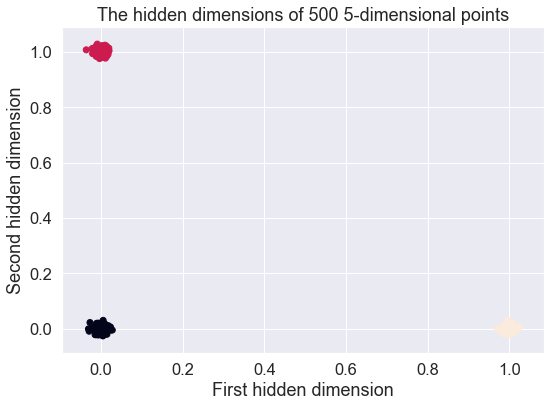

In [18]:
n_sub = 500 # a small amount of data

from scipy.special import expit

X_sub = X_train[0:n_sub]
y_sub = y_train[0:n_sub]

# Get the hidden representations
hiddens = expit(np.dot(X_sub, aenn.coefs_[0]) + aenn.intercepts_[0])

# Plot
fig = plt.figure()
hiddens += np.random.randn(n_sub,2)*0.01 # add a bit of noise for vizualization purposes
plt.scatter(hiddens[:, 1], hiddens[:, 0], c=y_sub)
plt.xlabel('First hidden dimension')
plt.ylabel('Second hidden dimension')
plt.title('The hidden dimensions of %d %d-dimensional points' % (X_sub.shape))
plt.tight_layout()

**Questions 7.8**

1. Does the plot behave as expected? How so?
2. Run the same experiment again without changing the hyperparameters. What do you notice? Does the latent representation seems to have changed?
3. Would the plot have been different if we had simulated the data from 2 clusters instead of 4? Try it! 
4. How could you use the information represented in the hidden layers?

**Answers 7.8**

1. At first glance, the latent representations seem to have encoded the distributions associated with the 4 different clusters. In fact, most of the observations cluster at 4 different points, which are associated with each of the mixtures.
2. There is a good chance that it does! We can just see it by looking at the new figures above.
3. Absolutely! We would just have seen a maximum of two points on the subplots.
4. We could use the latent representation of each observation to subsequently associate it with a particular mixture, as we did in the sections about clustering.